In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-dataset/public_test.en.txt
/kaggle/input/nlp-dataset/train.en.txt
/kaggle/input/nlp-dataset/train.vi.txt
/kaggle/input/nlp-dataset/public_test.vi.txt


In [2]:
#1. Load dataset
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader

class ParallelTextDataset(Dataset):
    def __init__(self, src_file, tgt_file):
        self.data = []
        
        # Open both files together
        with open(src_file, 'r', encoding='utf-8') as f1, \
             open(tgt_file, 'r', encoding='utf-8') as f2:
            
            # zip() pairs line 1 with line 1, line 2 with line 2...
            for src_line, tgt_line in zip(f1, f2):
                if src_line.strip() and tgt_line.strip(): # Skip empty lines
                    self.data.append((src_line.strip(), tgt_line.strip()))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Usage
train_dataset = ParallelTextDataset(
    "/kaggle/input/nlp-dataset/train.en.txt", 
    "/kaggle/input/nlp-dataset/train.vi.txt"
)

#train_dataset = train_dataset.shuffle(seed=42).select(range(400000))


test_dataset = ParallelTextDataset(
    "/kaggle/input/nlp-dataset/public_test.en.txt",
    "/kaggle/input/nlp-dataset/public_test.vi.txt"
)

In [3]:
# Test it
for i in range(10):
    src, tgt = train_dataset[i]
    print(f"Source: {src}")
    print(f"Target: {tgt}")

print(len(train_dataset))

Source: To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital
Target: Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên
Source: Evaluate clinical, subclinical symptoms of patients with otittis media effusion and V a at otorhinolaryngology department - Thai Nguyên National Hospital.
Target: Đánh giá đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.a tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên.
Source: There was a relation between vasodilatation and vaginal dysfunction.
Target: Có sự liên quan giữa độ quá phát V.a với mức độ rối loạn chức năng vòi nhĩ.
Source: Otittis media effusion on V a is a common disease in children.
Target: Kết luận: Viêm tai ứ dịch trên viêm V.a là bệnh lý hay gặp ở lứa tuổi trẻ em.
Source: Main symptoms are rhinitis, nasal congestion, t

In [4]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers, decoders

print("\n=== TRAINING ENGLISH BYTE-LEVEL BPE TOKENIZER ===")

tokenizer_en = Tokenizer(models.BPE(unk_token="<unk>"))

# English: lowercase + strip accents
tokenizer_en.normalizer = normalizers.Sequence([
    normalizers.NFD(),
    normalizers.Lowercase(),
    normalizers.StripAccents(),
])

# Byte-level preserves whitespace (GPT2-style)
tokenizer_en.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
tokenizer_en.decoder = decoders.ByteLevel()

trainer_en = trainers.BpeTrainer(
    vocab_size=24000,
    special_tokens=["<pad>", "<unk>", "<sos>", "<eos>"],
)

def iter_english():
    for src, _ in train_dataset:
        yield src

tokenizer_en.train_from_iterator(iter_english(), trainer_en)
tokenizer_en.save("tokenizer_en.json")

print("✓ Saved English tokenizer (tokenizer_en.json)")



=== TRAINING ENGLISH BYTE-LEVEL BPE TOKENIZER ===



✓ Saved English tokenizer (tokenizer_en.json)


In [5]:
print("\n=== TRAINING VIETNAMESE BYTE-LEVEL BPE TOKENIZER ===")

tokenizer_vi = Tokenizer(models.BPE(unk_token="<unk>"))

# Vietnamese: NFC (keeps tone marks stable)
tokenizer_vi.normalizer = normalizers.NFC()

# Byte-level for correct whitespace + multi-byte Unicode
tokenizer_vi.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
tokenizer_vi.decoder = decoders.ByteLevel()

trainer_vi = trainers.BpeTrainer(
    vocab_size=28000, 
    special_tokens=["<pad>", "<unk>", "<sos>", "<eos>"],
)

def iter_vietnamese():
    for _, tgt in train_dataset:
        yield tgt

tokenizer_vi.train_from_iterator(iter_vietnamese(), trainer_vi)
tokenizer_vi.save("tokenizer_vi.json")

print("✓ Saved Vietnamese tokenizer (tokenizer_vi.json)")



=== TRAINING VIETNAMESE BYTE-LEVEL BPE TOKENIZER ===



✓ Saved Vietnamese tokenizer (tokenizer_vi.json)


In [6]:
from torch.nn.utils.rnn import pad_sequence

class Collate:
    def __init__(self, tokenizer_src, tokenizer_tgt, max_len=80):
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.max_len = max_len
        
        # Get IDs for special tokens
        self.sos_id = tokenizer_src.token_to_id("<sos>")
        self.eos_id = tokenizer_src.token_to_id("<eos>")
        self.pad_id = tokenizer_src.token_to_id("<pad>")

    def __call__(self, batch):
        src_batch, tgt_batch = [], []
        
        for src_text, tgt_text in batch:
            # 1. Encode
            src_encoded = self.tokenizer_src.encode(src_text).ids
            tgt_encoded = self.tokenizer_tgt.encode(tgt_text).ids

            # 2. Add <sos> and <eos> and Truncate if necessary
            # For Source: usually need <sos>...<eos> (or just <eos> depending on arch)
            src_ids = [self.sos_id] + src_encoded[:self.max_len-2] + [self.eos_id]
            # For Target: <sos>...<eos>
            tgt_ids = [self.sos_id] + tgt_encoded[:self.max_len-2] + [self.eos_id]

            src_batch.append(torch.tensor(src_ids))
            tgt_batch.append(torch.tensor(tgt_ids))

        # 3. Pad
        src_batch = pad_sequence(src_batch, padding_value=self.pad_id, batch_first=True)
        tgt_batch = pad_sequence(tgt_batch, padding_value=self.pad_id, batch_first=True)

        return src_batch, tgt_batch

# Initialize Dataloader
collate_fn = Collate(tokenizer_en, tokenizer_vi)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# ============================================================================
# 1. SCALED DOT-PRODUCT ATTENTION
# ============================================================================
class ScaledDotProductAttention(nn.Module):
    """
    Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
    """
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        """
        Args:
            query: (batch, n_heads, seq_len, d_k)
            key: (batch, n_heads, seq_len, d_k)
            value: (batch, n_heads, seq_len, d_v)
            mask: (batch, 1, seq_len, seq_len) or (batch, 1, 1, seq_len)
        Returns:
            output: (batch, n_heads, seq_len, d_v)
            attention_weights: (batch, n_heads, seq_len, seq_len)
        """
        d_k = query.size(-1)
        
        # (batch, n_heads, seq_len, seq_len)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        
        # Apply mask (set masked positions to large negative value)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Softmax over last dimension (key dimension)
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # (batch, n_heads, seq_len, d_v)
        output = torch.matmul(attention_weights, value)
        
        return output, attention_weights


# ============================================================================
# 2. MULTI-HEAD ATTENTION
# ============================================================================
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention allows the model to attend to information 
    from different representation subspaces.
    """
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Linear projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.attention = ScaledDotProductAttention(dropout)
        self.dropout = nn.Dropout(dropout)
    
    def split_heads(self, x):
        """
        Split the last dimension into (n_heads, d_k)
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            (batch, n_heads, seq_len, d_k)
        """
        batch_size, seq_len, d_model = x.size()
        return x.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
    
    def combine_heads(self, x):
        """
        Combine heads back
        Args:
            x: (batch, n_heads, seq_len, d_k)
        Returns:
            (batch, seq_len, d_model)
        """
        batch_size, n_heads, seq_len, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
    
    def forward(self, query, key, value, mask=None):
        """
        Args:
            query: (batch, seq_len_q, d_model)
            key: (batch, seq_len_k, d_model)
            value: (batch, seq_len_v, d_model)
            mask: (batch, 1, seq_len_q, seq_len_k)
        """
        # Linear projections
        Q = self.W_q(query)  # (batch, seq_len_q, d_model)
        K = self.W_k(key)    # (batch, seq_len_k, d_model)
        V = self.W_v(value)  # (batch, seq_len_v, d_model)
        
        # Split into multiple heads
        Q = self.split_heads(Q)  # (batch, n_heads, seq_len_q, d_k)
        K = self.split_heads(K)  # (batch, n_heads, seq_len_k, d_k)
        V = self.split_heads(V)  # (batch, n_heads, seq_len_v, d_k)
        
        # Apply attention
        attn_output, attn_weights = self.attention(Q, K, V, mask)
        
        # Combine heads
        attn_output = self.combine_heads(attn_output)  # (batch, seq_len_q, d_model)
        
        # Final linear projection
        output = self.W_o(attn_output)
        
        return output, attn_weights


# ============================================================================
# 3. POSITION-WISE FEED-FORWARD NETWORK
# ============================================================================
class PositionWiseFeedForward(nn.Module):
    """
    FFN(x) = max(0, xW1 + b1)W2 + b2
    Two linear transformations with ReLU activation in between.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # (batch, seq_len, d_model) -> (batch, seq_len, d_ff) -> (batch, seq_len, d_model)
        return self.fc2(self.dropout(F.relu(self.fc1(x))))


# ============================================================================
# 4. POSITIONAL ENCODING
# ============================================================================
class PositionalEncoding(nn.Module):
    """
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model, max_len=100, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: (batch, seq_len, d_model)
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# ============================================================================
# 5. ENCODER LAYER
# ============================================================================
class EncoderLayer(nn.Module):
    """
    Single encoder layer:
    1. Multi-head self-attention
    2. Add & Norm
    3. Feed-forward
    4. Add & Norm
    """
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        """
        Args:
            x: (batch, seq_len, d_model)
            mask: (batch, 1, 1, seq_len) - padding mask
        """
        # Self-attention with residual connection
        attn_output, _ = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        
        return x


# ============================================================================
# 6. DECODER LAYER
# ============================================================================
class DecoderLayer(nn.Module):
    """
    Single decoder layer:
    1. Masked multi-head self-attention
    2. Add & Norm
    3. Multi-head cross-attention (with encoder output)
    4. Add & Norm
    5. Feed-forward
    6. Add & Norm
    """
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        """
        Args:
            x: (batch, tgt_seq_len, d_model)
            enc_output: (batch, src_seq_len, d_model)
            src_mask: (batch, 1, 1, src_seq_len) - encoder padding mask
            tgt_mask: (batch, 1, tgt_seq_len, tgt_seq_len) - decoder causal + padding mask
        """
        # Masked self-attention
        attn_output, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Cross-attention with encoder output
        attn_output, _ = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout2(attn_output))
        
        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout3(ff_output))
        
        return x


# ============================================================================
# 7. ENCODER
# ============================================================================
class Encoder(nn.Module):
    """
    Stack of N encoder layers
    """
    def __init__(self, vocab_size, d_model, n_heads, d_ff, n_layers, dropout=0.1, max_len=100, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)
        
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(d_model)
    
    def forward(self, src, src_mask=None):
        """
        Args:
            src: (batch, src_seq_len)
            src_mask: (batch, 1, 1, src_seq_len)
        Returns:
            (batch, src_seq_len, d_model)
        """
        x = self.embedding(src) * self.scale
        x = self.pos_encoding(x)
        
        for layer in self.layers:
            x = layer(x, src_mask)
        
        return x


# ============================================================================
# 8. DECODER
# ============================================================================
class Decoder(nn.Module):
    """
    Stack of N decoder layers
    """
    def __init__(self, vocab_size, d_model, n_heads, d_ff, n_layers, dropout=0.1, max_len=100, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)
        
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(d_model)
    
    def forward(self, tgt, enc_output, src_mask=None, tgt_mask=None):
        """
        Args:
            tgt: (batch, tgt_seq_len)
            enc_output: (batch, src_seq_len, d_model)
            src_mask: (batch, 1, 1, src_seq_len)
            tgt_mask: (batch, 1, tgt_seq_len, tgt_seq_len)
        Returns:
            (batch, tgt_seq_len, d_model)
        """
        x = self.embedding(tgt) * self.scale
        x = self.pos_encoding(x)
        
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        
        return x


# ============================================================================
# 9. COMPLETE TRANSFORMER MODEL
# ============================================================================
class Transformer(nn.Module):
    """
    Complete Transformer for sequence-to-sequence translation
    """
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model=384,
        n_heads=6,
        n_encoder_layers=4,
        n_decoder_layers=4,
        d_ff=1536,
        dropout=0.1,
        max_len=100,
        pad_idx=0
    ):
        super().__init__()
        
        self.pad_idx = pad_idx
        
        self.encoder = Encoder(
            src_vocab_size, d_model, n_heads, d_ff, 
            n_encoder_layers, dropout, max_len, pad_idx
        )
        
        self.decoder = Decoder(
            tgt_vocab_size, d_model, n_heads, d_ff, 
            n_decoder_layers, dropout, max_len, pad_idx
        )
        
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

        # --- OPTIMIZATION START ---
        # 1. Create the full-sized mask once (max_len x max_len)
        #    This creates the upper triangular matrix (future positions)
        mask = torch.triu(torch.ones(max_len, max_len), diagonal=1).bool()
        
        # 2. Invert it (True = visible, False = hidden) so it matches your logic
        #    (Your original code used ~mask, so we store the inverted version)
        causal_mask = ~mask 
        
        # 3. Register as a buffer
        #    'causal_mask' becomes accessible as self.causal_mask
        #    It will automatically move to GPU when you do model.to(device)
        self.register_buffer('causal_mask', causal_mask)
        # --- OPTIMIZATION END ---
        # Initialize parameters
        self._init_parameters()
    
    def _init_parameters(self):
        """Initialize parameters with Xavier uniform"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def create_padding_mask(self, seq):
        """
        Create padding mask
        Args:
            seq: (batch, seq_len)
        Returns:
            (batch, 1, 1, seq_len)
        """
        # 1 where token is not pad, 0 where it is pad
        mask = (seq != self.pad_idx).unsqueeze(1).unsqueeze(2)
        return mask
    
    
    def forward(self, src, tgt):
        """
        Args:
            src: (batch, src_seq_len)
            tgt: (batch, tgt_seq_len)
        Returns:
            (batch, tgt_seq_len, tgt_vocab_size)
        """
        # Get the current sequence length (e.g., 32, 50, etc.)
        seq_len = tgt.size(1)
        
        # Create masks
        src_mask = self.create_padding_mask(src)
        tgt_padding_mask = self.create_padding_mask(tgt)
        
        # --- OPTIMIZATION START ---
        # Slice the pre-made buffer. 
        # No .to(device) needed! It's already there.
        # Reshape to (1, 1, seq_len, seq_len) to match attention logic
        tgt_causal_mask = self.causal_mask[:seq_len, :seq_len].unsqueeze(0).unsqueeze(0)
        # --- OPTIMIZATION END ---
        
        # Combine target masks
        tgt_mask = tgt_padding_mask & tgt_causal_mask
        
        # Encode
        enc_output = self.encoder(src, src_mask)
        
        # Decode
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        
        # Project to vocabulary
        output = self.fc_out(dec_output)
        
        return output
    
    def encode(self, src):
        """Encode source sequence"""
        src_mask = self.create_padding_mask(src)
        return self.encoder(src, src_mask)
    
    def decode(self, tgt, enc_output, src_mask):
        """Decode one step"""
        tgt_mask = self.create_causal_mask(tgt.size(1)).to(tgt.device)
        tgt_padding_mask = self.create_padding_mask(tgt)
        tgt_mask = tgt_padding_mask & tgt_mask
        
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        return self.fc_out(dec_output)




In [8]:
!pip install torchmetrics

from torchmetrics.text import BLEUScore

def calculate_bleu(model, dataloader, tokenizer_src, tokenizer_tgt, device, max_batches=None):
    """
    Calculates BLEU score on the validation set.
    
    Args:
        max_batches (int): Limit the number of batches to speed up evaluation (optional)
    """
    model.eval()
    metric = BLEUScore()
    
    # Store predictions and references
    preds = []
    targets = []
    
    with torch.no_grad():
        for batch_idx, (src, tgt) in enumerate(tqdm(dataloader, desc="Calculating BLEU")):
            # Optional: Stop early if it takes too long
            if max_batches and batch_idx >= max_batches:
                break

            src = src.to(device)
            
            # 1. Iterate over the batch (Since your greedy_decode is single-sample)
            # Optimization note: Writing a batch_greedy_decode function would be faster,
            # but looping is safer with your current code structure.
            for i in range(src.size(0)):
                # Get single source sentence tensor: (1, seq_len)
                src_tensor = src[i].unsqueeze(0)
                
                # Decode (Generate prediction)
                # Note: We use your existing greedy_decode function
                pred_tokens = greedy_decode(model, src_tensor, tokenizer_tgt, device)
                
                # Convert IDs to Text (remove <sos>, <eos>, <pad>)
                pred_text = tokenizer_tgt.decode(pred_tokens, skip_special_tokens=True)
                
                # Get Reference Text
                # tgt[i] is the reference tensor
                ref_tokens = tgt[i].tolist()
                ref_text = tokenizer_tgt.decode(ref_tokens, skip_special_tokens=True)
                
                preds.append(pred_text)
                # BLEU expects a list of references for each prediction (e.g. [[ref1], [ref2]])
                targets.append([ref_text])
                
    # Compute Final BLEU Score
    score = metric(preds, targets)
    return score.item()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [9]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import math
import time
from tqdm import tqdm
import os

# ============================================================================
# 1. LEARNING RATE SCHEDULER (Transformer Warmup)
# ============================================================================
class TransformerLRScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0
    
    def step(self):
        self.step_num += 1
        lr = self._get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
    
    def _get_lr(self):
        step = max(self.step_num, 1)
        return (self.d_model ** -0.5) * min(
            step ** -0.5, 
            step * (self.warmup_steps ** -1.5)
        )
    
    def get_last_lr(self):
        return [self._get_lr()]

# ============================================================================
# 2. TRAINING FUNCTION
# ============================================================================
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, grad_clip=1.0):
    model.train()
    total_loss = 0
    total_tokens = 0
    
    pbar = tqdm(dataloader, desc="Training")
    
    for batch_idx, (src, tgt) in enumerate(pbar):
        src = src.to(device)
        tgt = tgt.to(device)
        
        # Target input (without last token) and output (without first token)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, tgt_input)
        
        # Reshape for loss calculation
        # output: (batch, seq_len, vocab_size) -> (batch * seq_len, vocab_size)
        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)
        
        # Calculate loss
        loss = criterion(output, tgt_output)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        # Update weights
        optimizer.step()
        scheduler.step()
        
        # Update statistics
        total_loss += loss.item()
        # total_tokens += (tgt_output != model.pad_idx).sum().item() # Optional token counting
        
        # Update progress bar
        pbar.set_postfix({
            'loss': loss.item(),
            'avg_loss': total_loss / (batch_idx + 1),
            'lr': scheduler.get_last_lr()[0]
        })
    
    return total_loss / len(dataloader)

# ============================================================================
# 3. VALIDATION FUNCTION
# ============================================================================
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc="Validation"):
            src = src.to(device)
            tgt = tgt.to(device)
            
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            output = model(src, tgt_input)
            
            output = output.reshape(-1, output.size(-1))
            tgt_output = tgt_output.reshape(-1)
            
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

# ============================================================================
# 4. GREEDY DECODING (FOR INFERENCE)
# ============================================================================
def greedy_decode(model, src, tokenizer_tgt, device, max_len=128):
    model.eval()
    src = src.to(device)
    
    # Encode source
    with torch.no_grad():
        enc_output = model.encode(src)
        src_mask = model.create_padding_mask(src)
    
    # Start with <sos> token
    sos_idx = tokenizer_tgt.token_to_id("<sos>")
    eos_idx = tokenizer_tgt.token_to_id("<eos>")
    
    tgt_tokens = [sos_idx]
    
    for _ in range(max_len):
        tgt = torch.LongTensor([tgt_tokens]).to(device)
        
        with torch.no_grad():
            output = model.decode(tgt, enc_output, src_mask)
        
        # Get the last token prediction
        next_token_logits = output[0, -1, :]
        next_token = next_token_logits.argmax().item()
        
        tgt_tokens.append(next_token)
        
        if next_token == eos_idx:
            break
    
    return tgt_tokens

# ============================================================================
# 5. TRANSLATION FUNCTION
# ============================================================================
def translate(model, src_text, tokenizer_src, tokenizer_tgt, device, max_len=128):
    model.eval()
    
    sos_idx = tokenizer_src.token_to_id("<sos>")
    eos_idx = tokenizer_src.token_to_id("<eos>")
    
    # Tokenize source
    src_ids = [sos_idx] + tokenizer_src.encode(src_text).ids + [eos_idx]
    src = torch.LongTensor([src_ids])
    
    tgt_tokens = greedy_decode(model, src, tokenizer_tgt, device, max_len)
    
    # Convert to text (remove <sos> and <eos>)
    tgt_text = tokenizer_tgt.decode(tgt_tokens[1:-1])
    
    return tgt_text

# ============================================================================
# 6. HELPER: BLEU SCORE PLACEHOLDER (ADDED TO FIX MISSING FUNCTION ERROR)
# ============================================================================
def calculate_bleu(model, dataloader, tokenizer_src, tokenizer_tgt, device, max_batches=None):
    """
    Placeholder for BLEU calculation to prevent NameError.
    You should implement the actual BLEU logic using torchtext or sacrebleu.
    """
    print("\n[NOTE] calculate_bleu is a placeholder. Logic needs to be implemented.")
    return 0.0

# ============================================================================
# 7. MAIN TRAINING LOOP
# ============================================================================
def train_model(
    model,
    train_loader,
    val_loader,
    tokenizer_src,
    tokenizer_tgt,
    device,
    num_epochs=25,
    d_model=384,
    warmup_steps=6000,
    grad_clip=1.0,
    save_dir="checkpoints",
    print_every=1,
    bleu_max_batches=None, 
    early_stopping=True,
    patience=5
):
    os.makedirs(save_dir, exist_ok=True)

    # Note: Ensure your model has a 'pad_idx' attribute or pass it explicitly
    criterion = nn.CrossEntropyLoss(ignore_index=model.pad_idx, label_smoothing=0.1)
    optimizer = Adam(model.parameters(), lr=1.0, betas=(0.9, 0.98), eps=1e-9)
    scheduler = TransformerLRScheduler(optimizer, d_model, warmup_steps)

    history = {
        'train_loss': [],
        'val_loss': []
    }

    best_val_loss = float('inf')
    no_improve_epochs = 0

    print(f"Starting training on {device}")
    print("BLEU calculation disabled during training. Will run once at the end.")
    print("=" * 70)

    for epoch in range(1, num_epochs + 1):
        # 1. TRAIN
        train_loss = train_epoch(
            model, train_loader, criterion, optimizer, scheduler, device, grad_clip
        )

        # 2. VALIDATE
        val_loss = None
        if val_loader is not None:
            val_loss = validate(model, val_loader, criterion, device)

        # 3. RECORD & PRINT
        history['train_loss'].append(train_loss)
        if val_loss is not None:
            history['val_loss'].append(val_loss)

        print(f"\nEpoch {epoch}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        if val_loss is not None:
            print(f"  Val Loss:   {val_loss:.4f}")

        # 4. SAVE CHECKPOINTS
        if val_loss is not None and val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, f"{save_dir}/best_model.pt")
            print(f"  ✓ Saved best model (val_loss={val_loss:.4f})")
        else:
            no_improve_epochs += 1
            print(f"  No improvement for {no_improve_epochs} epoch(s).")

        # EARLY STOPPING
        if early_stopping and no_improve_epochs >= patience:
            print("\n🛑 Early stopping triggered!")
            break

        # 5. SAMPLE TRANSLATIONS
        if epoch % print_every == 0:
            pass # Add your custom sample printing logic here

    # ========================================================================
    # FINAL EVALUATION
    # ========================================================================
    print("\n" + "=" * 70)
    print("TRAINING FINISHED. CALCULATING FINAL BLEU...")
    print("=" * 70)

    # Load best model
    best_checkpoint_path = f"{save_dir}/best_model.pt"
    if os.path.exists(best_checkpoint_path):
        print(f"Loading best checkpoint from {best_checkpoint_path}...")
        checkpoint = torch.load(best_checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
    
    # Calculate BLEU
    if val_loader is not None:
        final_bleu = calculate_bleu(
            model,
            val_loader,
            tokenizer_src,
            tokenizer_tgt,
            device,
            max_batches=bleu_max_batches 
        )
        print(f"\n🏆 Final BLEU Score (Best Model): {final_bleu:.4f}")
        history['final_bleu'] = final_bleu

    return history

In [10]:
# Model parameters
src_vocab_size = 24000
tgt_vocab_size = 28000
d_model = 384
n_heads = 6
n_encoder_layers = 4
n_decoder_layers = 4
d_ff = 1536
dropout = 0.1
pad_idx = 0

# Create model
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    d_ff=d_ff,
    dropout=dropout,
    pad_idx=pad_idx
)

# Example input
batch_size = 64
src_seq_len = 20
tgt_seq_len = 25

src = torch.randint(1, src_vocab_size, (batch_size, src_seq_len))
tgt = torch.randint(1, tgt_vocab_size, (batch_size, tgt_seq_len))

# Forward pass
output = model(src, tgt)

print(f"Model created successfully!")
print(f"Input source shape: {src.shape}")
print(f"Input target shape: {tgt.shape}")
print(f"Output shape: {output.shape}")
print(f"Expected output shape: (batch_size={batch_size}, tgt_seq_len={tgt_seq_len}, tgt_vocab_size={tgt_vocab_size})")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Model created successfully!
Input source shape: torch.Size([64, 20])
Input target shape: torch.Size([64, 25])
Output shape: torch.Size([64, 25, 28000])
Expected output shape: (batch_size=64, tgt_seq_len=25, tgt_vocab_size=28000)

Total parameters: 47,312,224


In [11]:
def check_data_alignment(dataloader, tokenizer_src, tokenizer_tgt):
    print("🔎 INSPECTING DATA ALIGNMENT...")
    
    # Get one batch
    src_batch, tgt_batch = next(iter(dataloader))
    
    # Check the first 3 examples in the batch
    for i in range(3):
        print(f"\n--- Example {i+1} ---")
        
        # Get raw IDs
        src_ids = src_batch[i].numpy()
        tgt_ids = tgt_batch[i].numpy()
        
        # Decode back to text (removing padding for readability)
        # Note: We skip special tokens like <sos>, <eos>, <pad> to see the raw content
        src_text = tokenizer_src.decode(src_ids, skip_special_tokens=True)
        tgt_text = tokenizer_tgt.decode(tgt_ids, skip_special_tokens=True)
        
        print(f"SRC (Input):  {src_text}")
        print(f"TGT (Label):  {tgt_text}")
        print(f"SRC IDs:      {src_ids[:10]}...") # Print first 10 IDs
        print(f"TGT IDs:      {tgt_ids[:10]}...")

# Run this before your training loop
check_data_alignment(train_loader, tokenizer_en, tokenizer_vi)

🔎 INSPECTING DATA ALIGNMENT...

--- Example 1 ---
SRC (Input):   chromosomal disorders of embryos in the 5th day with mother’s age in in-vitro fertilization
TGT (Label):   Liên quan giữa rối loạn nhiễm sắc thể ở phôi ngày 5 với tuổi mẹ trong thụ tinh trong ống nghiệm
SRC IDs:      [   2 6669  892  165 8743  159  158  335  271  564]...
TGT IDs:      [   2 3226  409  671  685  606  489 1294  298  299]...

--- Example 2 ---
SRC (Input):   patients and method: case series on all patients diagnosed mediastinal tumors at children's hospital 1 and 2 in the period of time mentioned above.
TGT (Label):   Đối tượng và phương pháp nghiên cứu: Mô tả các bệnh nhi dưới 15 tuổi được chẩn đoán u trung thất tại bệnh viện Nhi Đồng 1 và Nhi Đồng 2 trong thời gian trên.
SRC IDs:      [   2  226  177  656   29  978 2712  256  608  226]...
TGT IDs:      [   2  761  708  216  530  404  420  328   29 1278]...

--- Example 3 ---
SRC (Input):   - number of metastatic lymph nodes was 2.77 ± 3.8.
TGT (Label):   -

Using device: cuda
Source vocab size: 24000
Target vocab size: 28000
Starting training on cuda
BLEU calculation disabled during training. Will run once at the end.


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.54it/s]



Epoch 1/25
  Train Loss: 26.4573
  Val Loss:   7.5052
  ✓ Saved best model (val_loss=7.5052)


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.57it/s]



Epoch 2/25
  Train Loss: 7.4577
  Val Loss:   7.4360
  ✓ Saved best model (val_loss=7.4360)


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.67it/s]



Epoch 3/25
  Train Loss: 7.4436
  Val Loss:   7.4251
  ✓ Saved best model (val_loss=7.4251)


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.52it/s]



Epoch 4/25
  Train Loss: 7.4378
  Val Loss:   7.4252
  No improvement for 1 epoch(s).


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.42it/s]



Epoch 5/25
  Train Loss: 7.4340
  Val Loss:   7.4331
  No improvement for 2 epoch(s).


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.65it/s]



Epoch 6/25
  Train Loss: 7.4311
  Val Loss:   7.4234
  ✓ Saved best model (val_loss=7.4234)


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.65it/s]



Epoch 7/25
  Train Loss: 7.4288
  Val Loss:   7.4337
  No improvement for 1 epoch(s).


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.45it/s]



Epoch 8/25
  Train Loss: 7.4263
  Val Loss:   7.4907
  No improvement for 2 epoch(s).


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.57it/s]



Epoch 9/25
  Train Loss: 7.4242
  Val Loss:   7.4705
  No improvement for 3 epoch(s).


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.38it/s]



Epoch 10/25
  Train Loss: 7.4221
  Val Loss:   7.6527
  No improvement for 4 epoch(s).


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.35it/s]



Epoch 11/25
  Train Loss: 7.4186
  Val Loss:   35.6030
  No improvement for 5 epoch(s).

🛑 Early stopping triggered!

TRAINING FINISHED. CALCULATING FINAL BLEU...
Loading best checkpoint from checkpoints/best_model.pt...

[NOTE] calculate_bleu is a placeholder. Logic needs to be implemented.

🏆 Final BLEU Score (Best Model): 0.0000

Training completed!
Saved training history plot to 'training_history.png'


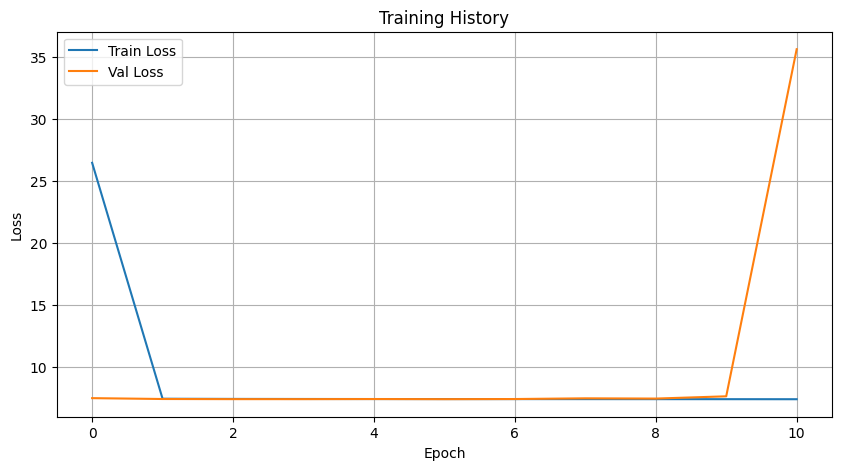

In [12]:
"""
Complete training script using your data and tokenizers
"""

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load tokenizers (assuming you have them from your code)
from tokenizers import Tokenizer
tokenizer_en = Tokenizer.from_file("tokenizer_en.json")
tokenizer_vi = Tokenizer.from_file("tokenizer_vi.json")

# Get vocab sizes
src_vocab_size = tokenizer_en.get_vocab_size()
tgt_vocab_size = tokenizer_vi.get_vocab_size()
pad_idx = tokenizer_en.token_to_id("<pad>")

print(f"Source vocab size: {src_vocab_size}")
print(f"Target vocab size: {tgt_vocab_size}")

# Initialize model
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=384,
    n_heads=6,
    n_encoder_layers=4,
    n_decoder_layers=4,
    d_ff=1536,
    dropout=0.1,
    pad_idx=pad_idx
).to(device)

# Create data loaders (using your Collate class and datasets)
from torch.utils.data import DataLoader
# Assuming you have: train_dataset, test_dataset, collate_fn

train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True, 
    collate_fn=collate_fn
)

val_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False, 
    collate_fn=collate_fn
)

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer_src=tokenizer_en,
    tokenizer_tgt=tokenizer_vi,
    device=device,
    num_epochs=25,
    d_model=384,
    warmup_steps=6000,
    grad_clip=1.0,
    save_dir="checkpoints",
    print_every=3
)

print("\nTraining completed!")

# Plot training history (optional)
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    if history['val_loss']:
        plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_history.png')
    print("Saved training history plot to 'training_history.png'")
except ImportError:
    print("Matplotlib not available for plotting")